#### Making Plots for the Research Paper

In [1]:
from MCM_functions import *

In [53]:
def make_realistic_projections2(raw_projs, sigma_x=0.11, sigma_y=0.137, projection_size_au=6.87, total_counts=0, four_sym=None):
    """
    raw_projs: shape (N, N, nproj)
    Returns: processed_projs (N, N, nproj)
    For ACAR measurement with 10x10au (73x73mRad) dimensions, and 129x129 pixel size, 
    each pixel is ≈0.564mRad; =0.5682mRad for 128x128 pixel size.
    
    Note: x-convolution is about 0.8mRad/0.11au, y-convolution is about 1.0mRad/0.137au.
    sigma * 2.354 = FWHM, so FWHM ≈ 0.137au, then just make sure to convert this back into
    channels (gotta know the units): 0.137/0.0775, and for the sigma we have 2.355
    """
    N, _, nproj = raw_projs.shape
    processed = np.zeros_like(raw_projs)
    msf_stack = []
    for idx in range(nproj):
        proj = raw_projs[:, :, idx]
        # 1. Elliptical detector convolution
        proj = apply_elliptical_gaussian(proj, sigma_x, sigma_y, projection_size_au, N=N)
        # # 2. MSF convolution (placeholder)
        c_simulated = np.loadtxt("c_simulated_513x513.txt").reshape((N, N))  # Load the simulated camera response
        msf = MSF_convolution(c_simulated, grid_size=proj.shape)    # <-- FIXED HERE
        proj = proj * msf                                        
        msf_stack.append(msf)
    #     # 3. Scale to total_counts
        proj_sum = np.sum(proj)
        if proj_sum > 0:
            proj = proj * (total_counts / proj_sum)
            # proj = proj * (1 / proj_sum)                # normalize the sum of the projections as 1

    #     # # 4. Poisson noise (integer counts)
        proj_torch = torch.tensor(proj, dtype=torch.float32)
        proj_noisy = torch.poisson(proj_torch).numpy()
        # proj_noisy = proj.copy()                              # To Test Without Noise
        
        if four_sym==True:
            # 6. Enforce 4-fold symmetry
            proj_noisy = symmetrize_4fold(proj_noisy)  # Enforce 4-fold symmetry
        
    #     # 5. Divide by MSF (avoid division by zero)
        proj_final = np.where(msf != 0, proj_noisy / msf, 0)
        
    #     """new addition: normalize projections"""
    #     if np.sum(proj_final) > 0:
    #         proj_final = proj_final * (proj_sum / total_counts)      # return the intensity back to the original total_counts

        
            

        processed[:, :, idx] = proj_final  #proj_final
    return processed

In [54]:
base_dir = "TPMD_Rand"
rho_real_dir = os.path.join(base_dir, "Rho_Real")
# rho_real_dir = os.path.join(base_dir, "Rho_Real2_25M")
# rho_real_dir = os.path.join(base_dir, "Rho_Real2_10M")
os.makedirs(rho_real_dir, exist_ok=True)

rho_ideal_dir = os.path.join(base_dir, "Rho_Ideal")
os.makedirs(rho_ideal_dir, exist_ok=True)

# Find the indices in pang closest to each value in comp_pang
pang = np.linspace(0, 45, 20)
comp_pang = np.array([0, 12.2, 24, 35, 45])
selected_indices = [np.abs(pang - val).argmin() for val in comp_pang]
pang_measure = pang[selected_indices]


# Load your raw projections (replace with your loader if needed)
# N = 129  # or 129, adjust as needed
# raw_proj_dir = "/Users/geno/Documents/GitHub/MSci-Project/ACAR_Tomography/Cu_20Projections"
N = 513
raw_proj_dir = "Cu_20Projections(513)"

file_names = [f"I_TPMD2D.OUT_PROJ_{i+1}" for i in range(20)]
raw_projs = load_projections(raw_proj_dir, file_names, N)                   # shape (N, N, 20)

file_names_measure = [file_names[i] for i in selected_indices]                      # Load only 5 selected projections
real_projs = load_projections(raw_proj_dir, file_names_measure, N)                        # shape (N, N, 20)



print(raw_projs.shape)  # Should be (129, 129, 20)
print(real_projs.shape)  # Should be (129, 129, 20)


nproj = len(pang_measure)
ncoeffs = nproj * [120]
order = 4
nphi = 180
calib = 0.09808
xsize = (N + 1) // 2
# rhocut = 0    # 1 = don't cut off, 0 = cut off at flvl
# flvl = 100/2  #for resolution 128^2. 
# kt = 4.0

rhocut = 0      # 1 = don't cut off, 0 = cut off at flvl
# Choose flvl so the cutoff starts at your desired px (e.g., 256)
flvl = 256      # Center of cutoff
kt = 2.0        # Slope; increase for smoother, decrease for sharper

rhofn = rhocutoff(xsize, rhocut, flvl, kt)
sinmat = setupsin(nphi)


print(nproj)


"""Run the loop below to generate 'num_simulations' realistic projections, their corresponding rho_n, and save them as .txt files."""
num_simulations = 1    # How many random rho_n for copper with different noise levels do you want to generate? Will usually equate to the same number of random TPMD you want to generate, but you could just reuse the same generated Rho_ns to save time/storage.

count_ttl = 10_000_000  # What should the simulated total counts be? 200_000_000 corresponds to 3 months of measurements!

for idx in tqdm(range(1, num_simulations + 1), desc="Generating simulations"):
    # 1. Make realistic projections
    realistic_projs = make_realistic_projections2(
        real_projs, sigma_x=0.11, sigma_y=0.137, projection_size_au=6.87, total_counts=count_ttl, four_sym=True
    )
    
    
    # prev_projs = make_realistic_projections2(
    #     real_projs, sigma_x=0.11, sigma_y=0.137, projection_size_au=6.87, total_counts=count_ttl, four_sym=True
    # )
    
    # 2. Run getrho
    # rhoreturn_real = getrho(realistic_projs, order, nproj, calib, pang_measure, nphi, ncoeffs, rhofn, sinmat)
    
    

    # 3. Save as flattened .txt
    # save_path_measure = os.path.join(rho_real_dir, f"rhos_simulated_measurement_{idx:03d}.txt")
    # np.savetxt(save_path_measure, rhoreturn_real.flatten()[:, None])

(513, 513, 20)
(513, 513, 5)
5


Generating simulations: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


In [55]:
print(realistic_projs.shape)

(513, 513, 5)


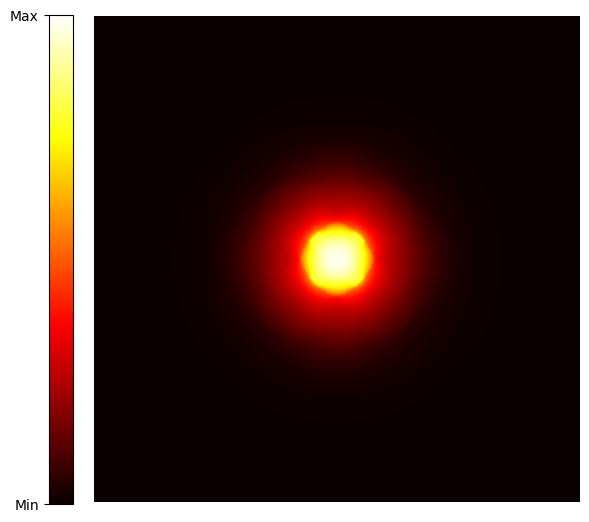

In [56]:
# Choose which projection to plot (0 to 4)
proj_idx = 0
real_projs[:, :, proj_idx] = real_projs[:, :, proj_idx] / np.max(np.abs(real_projs[:, :, proj_idx]))

plt.figure(figsize=(6, 6))
# for proj_idx in range(5):
im = plt.imshow(real_projs[:, :, proj_idx], cmap='hot', origin='lower', aspect='equal')
# plt.title(f'Projection {proj_idx+1} (Angle: {pang_measure[proj_idx]:.1f}°)')
plt.axis('off')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04, location='left')
cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
cbar.set_ticklabels(['Min', 'Max'])
plt.tight_layout()
# plt.savefig(f"projection{proj_idx}.png", dpi=300)
plt.show()

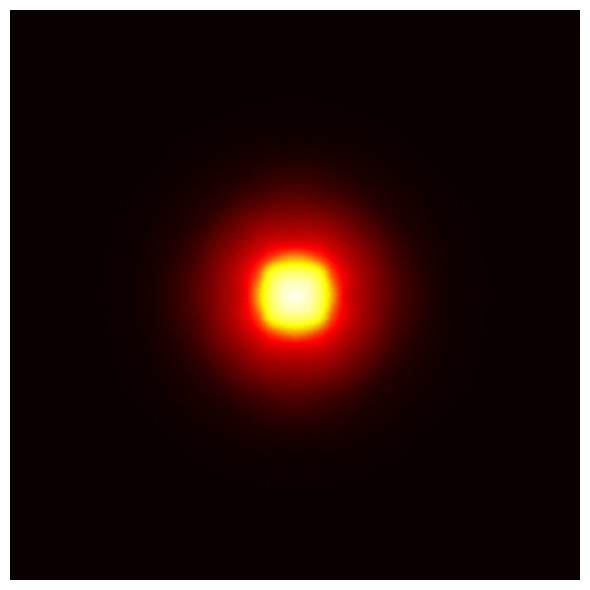

In [57]:
# Also plot the ideal projection for comparison
realistic_projs[:, :, proj_idx] = realistic_projs[:, :, proj_idx] / np.max(np.abs(realistic_projs[:, :, proj_idx]))

plt.figure(figsize=(6, 6))
im = plt.imshow(realistic_projs[:, :, proj_idx], cmap='hot', origin='lower', aspect='equal')
# plt.title(f'Projection {proj_idx+1} (Angle: {pang_measure[proj_idx]:.1f}°)')
plt.axis('off')
# cbar = plt.colorbar(im, fraction=0.046, pad=0.04, location='left') #label='Intensity', 
# cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
# cbar.set_ticklabels(['Min', 'Max'])
plt.tight_layout()
# plt.savefig(f"projection_smeared_msf_poisson_msf{proj_idx}.png", dpi=300)
plt.show()

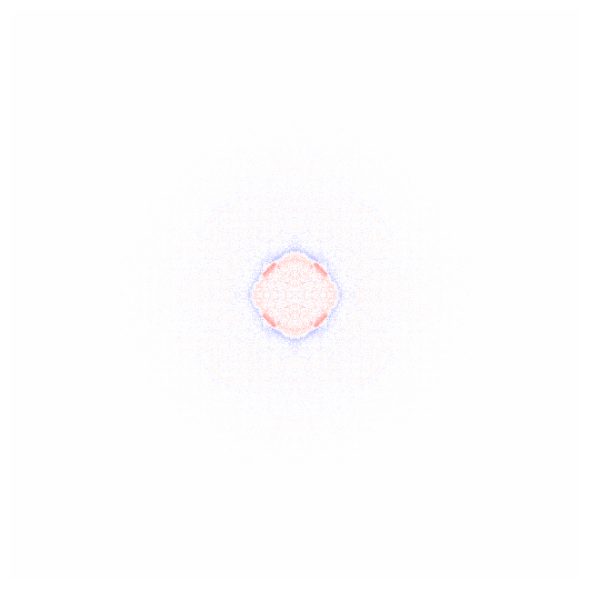

In [ ]:
# Choose which projection to plot (0 to 4)
proj_idx = 0

target_sum = np.sum(real_projs[:, :, proj_idx])  # or use np.sum(xz_slice_eval_meas), or the mean of both

real_projs[:, :, proj_idx] = real_projs[:, :, proj_idx] / np.sum(real_projs[:, :, proj_idx]) * target_sum
realistic_projs[:, :, proj_idx] = realistic_projs[:, :, proj_idx] / np.sum(realistic_projs[:, :, proj_idx]) * target_sum

with np.errstate(divide='ignore', invalid='ignore'):
    diff = (real_projs[:, :, proj_idx] - realistic_projs[:, :, proj_idx]) * 100 / (np.max(np.abs(realistic_projs[:, :, proj_idx])) or 1)
perc_range = np.max(np.abs(diff))

plt.figure(figsize=(6, 6))
perc_range = 24
im = plt.imshow(diff, cmap='bwr', origin='lower', aspect='equal', vmin=-perc_range, vmax=perc_range)
#plt.title(f'Projection {proj_idx+1} (Angle: {pang_measure[proj_idx]:.1f}°)')
plt.axis('off')
# cbar = plt.colorbar(im, fraction=0.046, pad=0.04, location='bottom') #, label='% Difference') 
# cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
# cbar.set_ticklabels(['Min', 'Max'])

plt.tight_layout()
# plt.savefig(f"projection_smeared{proj_idx}.png", dpi=300)
# plt.savefig(f"projection_smeared_msf{proj_idx}.png", dpi=300)
# plt.savefig(f"projection_smeared_msf_poisson{proj_idx}.png", dpi=300)
# plt.savefig(f"projection_smeared_msf_poisson_msf_percdiff{proj_idx}.png", dpi=300)
# plt.savefig(f"projection_smeared_msf_poisson_msf_4quads_percdiff{proj_idx}.png", dpi=300)
# plt.savefig(f"p_diff_cbar{proj_idx}.png", dpi=300)
plt.show()

In [61]:
get_them_rhos_dawg = getrho(raw_projs, order, 20, calib, pang, nphi, 20 * [120], rhofn, sinmat)


In [62]:
print(get_them_rhos_dawg.shape)   # (N/2, nproj, N/2)

(256, 20, 256)


In [63]:
rhoreturn_realzz = getrho(realistic_projs, order, nproj, calib, pang_measure, nphi, ncoeffs, rhofn, sinmat)

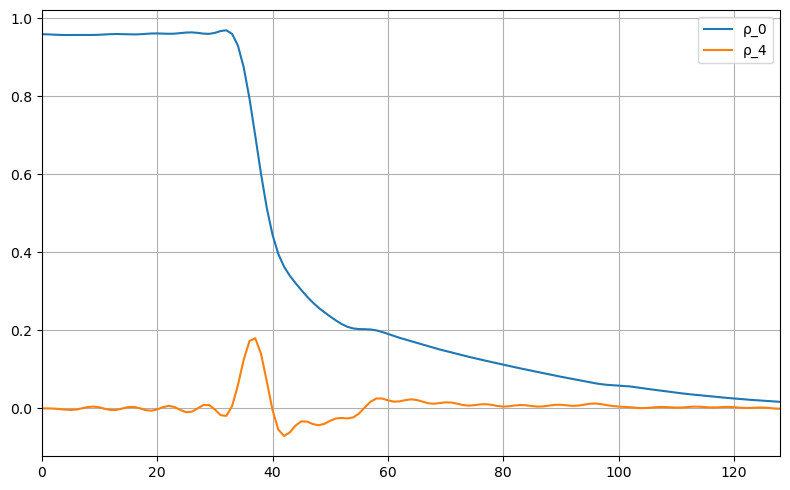

In [64]:
duhh = 0
# get_them_rhos_dawg = get_them_rhos_dawg[:, 0, :]
gtrd = get_them_rhos_dawg / np.max(np.abs(get_them_rhos_dawg))
plt.figure(figsize=(8, 5))
for rho_n in range(0, 2):
    first_row = gtrd[:, rho_n, duhh]
    scale_factor = np.max(np.abs(first_row))
    # rand_row = rhos[which_rand_rho][:, rho_n, duhh] #* (scale_factor / np.max(np.abs(rhos[which_rand_rho][:, rho_n, duhh])))
    # rand_row = rhos[:, rho_n, duhh]
    plt.plot(np.arange(len(first_row)), first_row, label=f'ρ_{4*rho_n}') #, linewidth=0.75)
    # plt.plot(np.arange(len(rand_row)), rand_row, label=f'rand_rho_{rho_n}')
# plt.title(f'Rhoreturn for slice {duhh}')
# plt.xlabel('px')
# plt.ylabel('rho_n (px)')
plt.xlim(0, 128)
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"rhos_n5.png", dpi=300)
plt.show()

# duhh = 0
# # rhoreturn_realzz = rhoreturn_realzz[:, 0, :]
# gtrd2 = rhoreturn_realzz / np.max(np.abs(rhoreturn_realzz))
# plt.figure(figsize=(8, 5))
# for rho_n in range(0, 2):
#     first_row = gtrd2[:, rho_n, duhh]
#     scale_factor = np.max(np.abs(first_row))
#     # rand_row = rhos[which_rand_rho][:, rho_n, duhh] #* (scale_factor / np.max(np.abs(rhos[which_rand_rho][:, rho_n, duhh])))
#     # rand_row = rhos[:, rho_n, duhh]
#     plt.plot(np.arange(len(first_row)), first_row, label=f'ρ_{4*rho_n}') #, linewidth=0.75)
#     # plt.plot(np.arange(len(rand_row)), rand_row, label=f'rand_rho_{rho_n}')
# # plt.title(f'Rhoreturn for slice {duhh}')
# # plt.xlabel('px')
# # plt.ylabel('rho_n (px)')
# plt.xlim(0, 128)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(f"rhos_n5.png", dpi=300)
# plt.show()

(256, 5, 256)
0.0027789567550358025


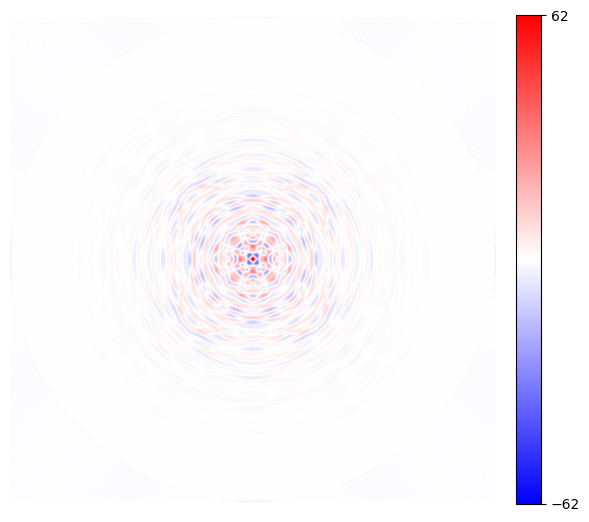

In [82]:
def calcplane(rhos, yfixed, nproj, xsize, order, iext=0):
    plane = np.zeros((2 * xsize, 2 * xsize))
    x_grid, z_grid = np.meshgrid(np.arange(2 * xsize), np.arange(2 * xsize), indexing='ij')
    x0 = xsize - 0.5

    if iext == 1:
        xdist = 0.5 * np.abs(x_grid - x0)
        zdist = 0.5 * np.abs(z_grid - x0)
    else:
        xdist = np.abs(x_grid - x0)
        zdist = np.abs(z_grid - x0)
    zdist[zdist <= 1e-3] = 1e-3

    theta = np.arctan2(x_grid - x0, zdist)
    p = np.sqrt(xdist ** 2 + zdist ** 2)
    intp = np.floor(p).astype(int)
    deltap = p - intp
    idx1 = np.clip(intp, 0, xsize - 2)
    idx2 = np.clip(intp + 1, 0, xsize - 1)

    for n in range(nproj):
        vals = ((1 - deltap) * rhos[idx1, n, yfixed] +
                deltap * rhos[idx2, n, yfixed]) * np.cos((n) * order * theta)
        # For points at the upper boundary, use only rhos[xsize-1, n, yfixed]
        mask = (intp == (xsize - 1))
        vals[mask] = rhos[xsize - 1, n, yfixed] * np.cos(n * order * theta[mask])
        plane += vals

    # plane = np.clip(plane, 0, None)  # Clip all negative values to zero
    return plane

N = 512 
xsize = N // 2
order = 4
central_y = 64
which_rand_rho = 0


getssss = rhoreturn_realzz
nproj = getssss.shape[1]




recon_3d_ideal = np.zeros((N, 1, N))
recon_3d_meas = np.zeros((N, 1, N))

# which_rho_n = 0
recon_3d_ideal[:, 0, :] = calcplane(get_them_rhos_dawg, central_y, 20, xsize, order)
recon_3d_meas[:, 0, :] = calcplane(getssss, central_y, 5, xsize, order)

target_sum = np.sum(recon_3d_ideal[:, 0, :])
recon_3d_ideal[:, 0, :] = recon_3d_ideal[:, 0, :] / np.sum(recon_3d_ideal[:, 0, :]) * target_sum
recon_3d_meas[:, 0, :] = recon_3d_meas[:, 0, :] / np.sum(recon_3d_meas[:, 0, :]) * target_sum

print(getssss.shape)
print(np.max(np.abs(recon_3d_ideal)))

# vlim = 0.014247095420365013
#which_rho_n:which_rho_n+1

with np.errstate(divide='ignore', invalid='ignore'):
    diff = (recon_3d_ideal[:, 0, :] - recon_3d_meas[:, 0, :]) * 100 / (np.max(np.abs(recon_3d_meas[:, 0, :])) or 1)
perc_range = np.max(np.abs(diff))
perc_range = 62

plt.figure(figsize=(6, 6))
im = plt.imshow(diff, cmap='bwr', origin='lower', aspect='equal', vmin=-perc_range, vmax=perc_range)

# im = plt.imshow(recon_3d_ideal[:, 0, :], cmap='hot', origin='lower', aspect='equal')#, vmin=-vlim, vmax=vlim)
# im = plt.imshow(recon_3d_meas[:, 0, :], cmap='hot', origin='lower', aspect='equal')#, vmin=-vlim, vmax=vlim)
# plt.title(f'Projection {proj_idx+1} (Angle: {pang_measure[proj_idx]:.1f}°)')
plt.axis('off')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04, location='right') #label='Intensity', 
cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
# cbar.set_ticklabels(['Min', 'Max'])
plt.tight_layout()
# plt.savefig(f"pdiff_recon_px{central_y}.png", dpi=300)
plt.savefig(f"pdiff_10MCR_Bar.png", dpi=300)
plt.show()

In [ ]:
# Choose which projection to plot (0 to 4)
proj_idx = 0

target_sum = np.sum(real_projs[:, :, proj_idx])  # or use np.sum(xz_slice_eval_meas), or the mean of both

real_projs[:, :, proj_idx] = real_projs[:, :, proj_idx] / np.sum(real_projs[:, :, proj_idx]) * target_sum
realistic_projs[:, :, proj_idx] = realistic_projs[:, :, proj_idx] / np.sum(realistic_projs[:, :, proj_idx]) * target_sum

with np.errstate(divide='ignore', invalid='ignore'):
    diff = (real_projs[:, :, proj_idx] - realistic_projs[:, :, proj_idx]) * 100 / (np.max(np.abs(realistic_projs[:, :, proj_idx])) or 1)
perc_range = np.max(np.abs(diff))

plt.figure(figsize=(6, 6))
perc_range = 24
im = plt.imshow(diff, cmap='bwr', origin='lower', aspect='equal', vmin=-perc_range, vmax=perc_range)
#plt.title(f'Projection {proj_idx+1} (Angle: {pang_measure[proj_idx]:.1f}°)')
plt.axis('off')
# cbar = plt.colorbar(im, fraction=0.046, pad=0.04, location='bottom') #, label='% Difference') 
# cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
# cbar.set_ticklabels(['Min', 'Max'])

plt.tight_layout()
# plt.savefig(f"projection_smeared{proj_idx}.png", dpi=300)
# plt.savefig(f"projection_smeared_msf{proj_idx}.png", dpi=300)
# plt.savefig(f"projection_smeared_msf_poisson{proj_idx}.png", dpi=300)
# plt.savefig(f"projection_smeared_msf_poisson_msf_percdiff{proj_idx}.png", dpi=300)
# plt.savefig(f"projection_smeared_msf_poisson_msf_4quads_percdiff{proj_idx}.png", dpi=300)
# plt.savefig(f"p_diff_cbar{proj_idx}.png", dpi=300)
plt.show()

(513,)


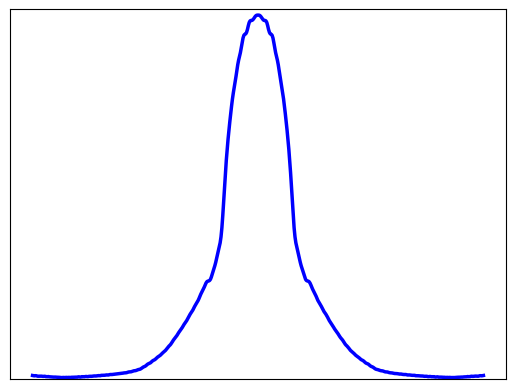

In [ ]:
import numpy as np
from skimage.transform import rotate

# img: 2D numpy array, shape (512, 512)
# angle: projection angle in degrees (0 = sum along x, 90 = sum along y)
# Returns: 1D projection (length 512)
def compute_projection(img, angle=0):
    """
    Compute the line integral (projection) of a 2D image at a given angle.

    Parameters:
        img (np.ndarray): 2D input image (e.g., shape (512, 512))
        angle (float): Angle in degrees (0 = sum along x, 90 = sum along y)

    Returns:
        np.ndarray: 1D projection (length = img.shape[0])
    """
    # Rotate the image by the given angle (centered)
    rotated = rotate(img, angle=angle, resize=False, order=1, mode='constant', cval=0.0, preserve_range=True)
    # Sum along columns (axis=0) to get projection
    projection = np.sum(rotated, axis=0)
    return projection

# Example usage:
img = recon_3d_ideal_get_them_rhos_dawg[:, 0, :] / np.max(np.abs(recon_3d_ideal_get_them_rhos_dawg[:, 0, :]))  # Normalize for better visualization
proj_0deg = compute_projection(img, angle=0)      # Projection at 0 degrees (sum along x)
proj_45deg = compute_projection(img, angle=45)    # Projection at 45 degrees

# Augment proj_0deg to have odd length (513) if it is length 512
if len(proj_0deg) == 512:
    proj_0deg_aug = np.zeros(513)
    proj_0deg_aug[:256] = proj_0deg[:256]
    proj_0deg_aug[256] = proj_0deg[255]
    proj_0deg_aug[257:] = proj_0deg[256:]
    proj_0deg = proj_0deg_aug

plt.plot(np.arange(len(proj_0deg)), proj_0deg, color='blue', linewidth=2.5)
# plt.plot(np.arange(len(proj_0deg)), proj_0deg, color='orange', linewidth=2.5)
plt.ylim(0, 100)
plt.xticks([])
plt.yticks([])
print(proj_0deg.shape)
# plt.savefig("proj_0deg.png", dpi=300)
# plt.savefig("proj_1deg.png", dpi=300)
plt.show()

In [580]:
import plotly.graph_objects as go
import numpy as np

# Assume proj_0deg is already defined and has length 513
N = len(proj_0deg)
r = np.linspace(-1, 1, N)  # Map indices to unit disk [-1, 1]
print(r.shape)
x = r
y = np.zeros_like(x)
# z = proj_0deg / np.max(proj_0deg) + 0.009 # Scale z for better visualization 
z = proj_45deg / np.max(proj_45deg) + 0.009 # Scale z for better visualization 

fig = go.Figure()

# Plot the projection curve (make sure it extends to the edge of the disk)
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines',
    line=dict(color='orange', width=10),
    name='Projection'
))

# Plot the zero baseline along the x-axis (dashed black line)
# fig.add_trace(go.Scatter3d(
#     x=x, y=y, z=np.zeros_like(z),
#     mode='lines',
#     line=dict(color='black', width=5, dash='dash'),
#     name='Projection Axis'
# ))

# Add filled unit disk (in-fill color white)
theta = np.linspace(0, 2 * np.pi, 400)
disk_x = np.cos(theta)
disk_y = np.sin(theta)
disk_z = np.zeros_like(theta)
fig.add_trace(go.Scatter3d(
    x=disk_x, y=disk_y, z=disk_z,
    mode='lines',
    line=dict(color='black', width=5),
    name='Unit Disk'
))

# # Add a dot at the origin
# fig.add_trace(go.Scatter3d(
#     x=[0], y=[0], z=[0],
#     mode='markers',
#     marker=dict(size=5, color='black', symbol='circle'),
#     name='Origin'
# ))

fig.update_layout(
    scene=dict(
        xaxis=dict(
            range=[-1, 1],
            showticklabels=False,
            showbackground=False,
            showgrid=False,
            gridcolor='grey',
            zeroline=False,
            title=''
        ),
        yaxis=dict(
            range=[-1, 1],
            showticklabels=False,
            showbackground=False,
            showgrid=False,
            gridcolor='grey',
            zeroline=False,
            title=''
        ),
        zaxis=dict(
            range=[0, np.max(z)],
            showticklabels=False,
            showbackground=False,
            showgrid=False,
            gridcolor='grey',
            zeroline=False,
            title=''
        ),
        aspectratio=dict(x=1, y=1, z=0.5),
        camera=dict(eye=dict(x=0, y=1.3, z=0.3)),
        bgcolor='white'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    title='Line Integral Projection Inside Unit Disk',
    width=int(0.5*900),
    height=int(0.5*700)
)

fig.show()

(513,)


## Top row:

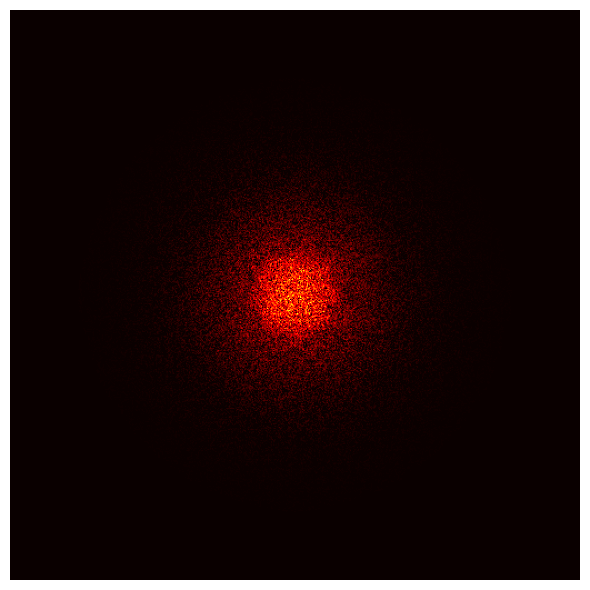

In [189]:
# Choose which projection to plot (0 to 4)
proj_idx = 0

with np.errstate(divide='ignore', invalid='ignore'):
    diff = 100 * (-realistic_projs[:, :, proj_idx] + prev_projs[:, :, proj_idx]/np.max(np.abs(prev_projs[:,:,proj_idx]))) #/ (np.max(np.abs(realistic_projs[:, :, proj_idx])) or 1)
perc_range = np.max(np.abs(diff))

plt.figure(figsize=(6, 6))
# perc_range = 22
im = plt.imshow(diff, cmap='hot', origin='lower', aspect='equal', vmin=0, vmax=perc_range)
#plt.title(f'Projection {proj_idx+1} (Angle: {pang_measure[proj_idx]:.1f}°)')
plt.axis('off')
# cbar = plt.colorbar(im, fraction=0.046, pad=0.04, location='bottom') #, label='% Difference') 
# cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
# cbar.set_ticklabels(['Min', 'Max'])

plt.tight_layout()
# plt.savefig(f"projection_smeared{proj_idx}.png", dpi=300)
# plt.savefig(f"projection_smeared_msf{proj_idx}.png", dpi=300)
plt.savefig(f"poisson_noise{proj_idx}.png", dpi=300)
# plt.savefig(f"projection_smeared_msf_poisson_msf_percdiff{proj_idx}.png", dpi=300)
# plt.savefig(f"p_diff_cbar{proj_idx}.png", dpi=300)
plt.show()

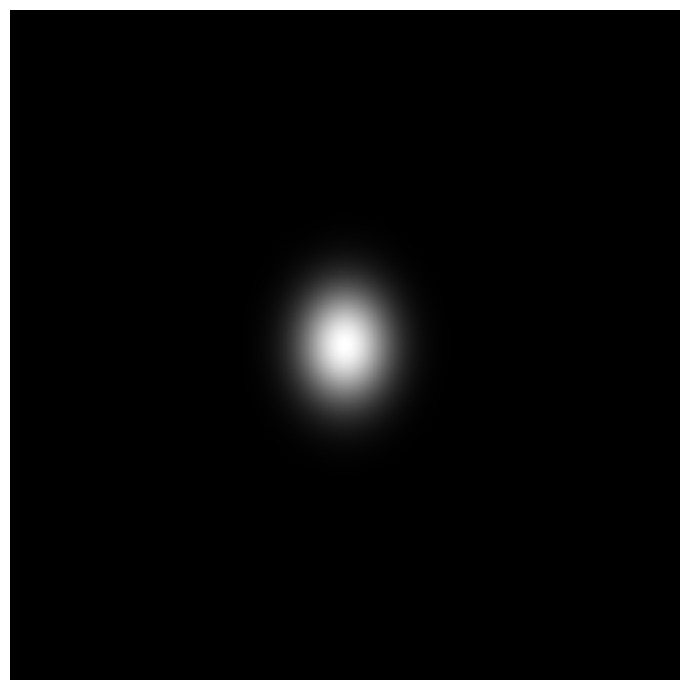

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def apply_elliptical_gaussian(img, sigma_x, sigma_y, projection_size_au=10, N=512):
    """
    Apply an elliptical Gaussian filter to a 2D image.

    Parameters:
        img (np.ndarray): 2D input image.
        sigma_x (float): FWHM in x (physical units).
        sigma_y (float): FWHM in y (physical units).
        projection_size_au (float): Physical size of the image (default 1.0).
        N (int): Number of pixels (default 512).

    Returns:
        np.ndarray: Blurred image.
    """
    pixel_size = projection_size_au / N
    sigma_x_pix = sigma_x / 2.355 / pixel_size
    sigma_y_pix = sigma_y / 2.355 / pixel_size
    return gaussian_filter(img, sigma=[sigma_y_pix, sigma_x_pix], mode='nearest')

# Create a test image: a delta function at the center
N = 513
img = np.zeros((N, N))
img[N//2, N//2] = 1

# Apply elliptical Gaussian
sigma_x = 0.11
sigma_y = 0.137
blurred = apply_elliptical_gaussian(img, sigma_x, sigma_y, projection_size_au=1.0, N=N)
blurred = blurred / np.max(blurred)  # Normalize for better visualization

# Plot with red concentric ellipses at every 0.1 increment of intensity
plt.figure(figsize=(7, 7))
im = plt.imshow(blurred, cmap='gray', origin='lower', aspect='equal')

# Add red concentric ellipses (contours) at every 0.1 increment
# levels = np.arange(0.1, 1.0, 0.1)
# ny, nx = blurred.shape
# x = np.arange(nx)
# y = np.arange(ny)
# X, Y = np.meshgrid(x, y)
# contours = plt.contour(X, Y, blurred, levels=levels, colors='white', linewidths=0.5, linestyles='solid')

plt.axis('off')
plt.savefig("elliptical_gaussian_blur.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.tight_layout()

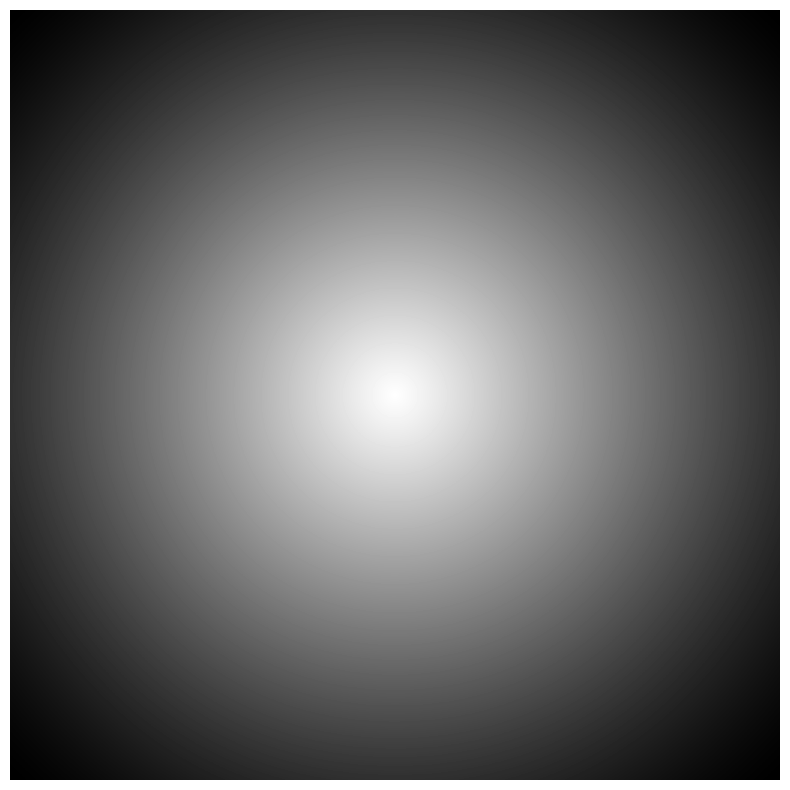

In [ ]:
def calcplane(rhos, yfixed, nproj, xsize, order, iext=0):
    plane = np.zeros((2 * xsize, 2 * xsize))
    x_grid, z_grid = np.meshgrid(np.arange(2 * xsize), np.arange(2 * xsize), indexing='ij')
    x0 = xsize - 0.5dtxt("c_simulated_513x513.txt").reshape((513, 513))

    if iext == 1:from_numpy(c_simulated.astype(np.float32))
        xdist = 0.5 * np.abs(x_grid - x0)1e-6)
        zdist = 0.5 * np.abs(z_grid - x0)mpy().astype(np.float64)
    else:= torch.poisson(c_tensor_pos).numpy().astype(np.float64)
        xdist = np.abs(x_grid - x0)1, c_noisy2)
        zdist = np.abs(z_grid - x0)
    zdist[zdist <= 1e-3] = 1e-3
# Convolve with itself using FFT for efficiency to get MSF tent function
    theta = np.arctan2(x_grid - x0, zdist)ulated, mode='same')
    p = np.sqrt(xdist ** 2 + zdist ** 2)y2, mode='same') 
    intp = np.floor(p).astype(int)volved)
    deltap = p - intp
    idx1 = np.clip(intp, 0, xsize - 2)ith concentric isocontours
    idx2 = np.clip(intp + 1, 0, xsize - 1)
im = plt.imshow(convolved, cmap='gray', origin='lower', aspect='equal')
    for n in range(nproj):fraction=0.046, pad=0.04, location='bottom')
        vals = ((1 - deltap) * rhos[idx1, n, yfixed] +
                deltap * rhos[idx2, n, yfixed]) * np.cos(n * order * theta)
        # For points at the upper boundary, use only rhos[xsize-1, n, yfixed]
        mask = (intp == (xsize - 1)).1 intensity increment
        vals[mask] = rhos[xsize - 1, n, yfixed] * np.cos(n * order * theta[mask])
        plane += valsshape
# x = np.arange(nx)
    plane = np.clip(plane, 0, None)  # Clip all negative values to zerony)
    return plane# X, Y = np.meshgrid(x, y)
rs = plt.contour(X, Y, convolved, levels=levels, colors='red', linewidths=1, linestyles='dashed', alpha=0.7)
N = 512 )
xsize = N // 2_layout()
order = 4MSF.png", dpi=300)
central_y = 0which_rand_rho = 0nproj = get_them_rhos_dawg.shape[1]recon_3d_ideal_get_them_rhos_dawg = np.zeros((N, 1, N))recon_3d_ideal_get_them_rhos_dawg[:, 0, :] = calcplane(get_them_rhos_dawg, central_y, nproj, xsize, order)print(get_them_rhos_dawg.shape)plt.figure(figsize=(6, 6))im = plt.imshow(recon_3d_ideal_get_them_rhos_dawg[:, 0, :], cmap='hot', origin='lower', aspect='equal')# plt.title(f'Projection {proj_idx+1} (Angle: {pang_measure[proj_idx]:.1f}°)')plt.axis('off')cbar = plt.colorbar(im, fraction=0.046, pad=0.04, location='left') #label='Intensity', cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])# cbar.set_ticklabels(['Min', 'Max'])plt.tight_layout()# plt.savefig(f"projection_smeared_msf_poisson_msf{proj_idx}.png", dpi=300)
plt.show()

In [66]:
# # Compute the inverse, avoiding division by zero
# convolved = convolved #+ 0.1  # Avoid division by zero
# msf_final = np.where(convolved != 0, 1 / convolved, 0)
# msf_final = np.clip(msf_final, 0, 5)  # Set all values > 20 to 20

# plt.figure(figsize=(8, 8))
# im = plt.imshow(msf_final, cmap='gray', origin='lower', aspect='equal')
# cbar = plt.colorbar(im, fraction=0.046, pad=0.04, location='bottom')
# # cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
# # cbar.set_ticklabels(['Min', 'Max'])
# plt.axis('off')
# plt.title('Inverse of convolved (1/msf)')
# plt.tight_layout()
# plt.show()

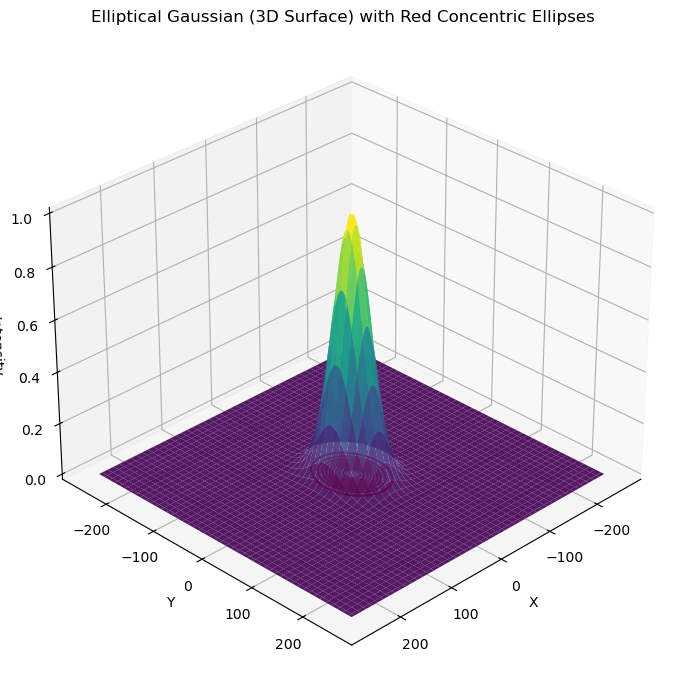

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D

# Function definition (as before)
def apply_elliptical_gaussian(img, sigma_x, sigma_y, projection_size_au=1.0, N=512):
    pixel_size = projection_size_au / N
    sigma_x_pix = sigma_x / 2.355 / pixel_size
    sigma_y_pix = sigma_y / 2.355 / pixel_size
    return gaussian_filter(img, sigma=[sigma_y_pix, sigma_x_pix], mode='nearest')

# Create a test image: a delta function at the center
N = 513
img = np.zeros((N, N))
img[N//2, N//2] = 1

# Apply elliptical Gaussian
sigma_x = 0.11
sigma_y = 0.137
blurred = apply_elliptical_gaussian(img, sigma_x, sigma_y, projection_size_au=1.0, N=N)
blurred = blurred / np.max(blurred)  # Normalize for better visualization

# 3D plot with red concentric ellipses at every 0.1 intensity increment
x = np.linspace(-N//2, N//2, N)
y = np.linspace(-N//2, N//2, N)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, blurred, cmap='viridis', linewidth=0, antialiased=True, alpha=0.9)

# Add red concentric ellipses (contours) at every 0.1 increment
levels = np.arange(0.1, 1.0, 0.1)
contour = ax.contour(X, Y, blurred, levels=levels, colors='red', linestyles='solid', linewidths=1.5, offset=0.0)

ax.set_title('Elliptical Gaussian (3D Surface) with Red Concentric Ellipses')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Intensity')
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()
